## Method

In [64]:
import scanpy as sc
import squidpy as sq
from multispaeti import MultispatiPCA
import spatialleiden as spl

from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [65]:
adata = sc.read_h5ad('151673.h5ad')
# Preprocess the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'sce.sample_name', 'sce.layer_guess'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'spatial_neighbors', 'transforms', 'log1p'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [66]:
groundtruth = adata.obs['sce.layer_guess']
n_clusters = groundtruth.nunique()
seed = 42
n_clusters

7

In [67]:
# string -> integers
encoder = LabelEncoder()

flat_arr = np.array([adata.obs['sce.layer_guess']]).ravel()
encoder.fit(flat_arr)

label_true = encoder.transform(flat_arr)

In [68]:

#selection
sc.tl.pca(adata, n_comps=50, random_state=seed)
sc.pp.neighbors(adata, random_state=seed)


sq.gr.spatial_neighbors(adata, coord_type="grid", n_neighs=6)
lantent_res1, spatial_res1 = spl.search_resolution(adata, n_clusters, 
                                           spatial_kwargs={"directed": (False, False),"layer_ratio": 0.7, "seed": seed})

sc.tl.leiden(adata, resolution= lantent_res1, key_added='leiden_pca', random_state=seed)
spl.spatialleiden(adata, key_added="spatialleiden_pca", layer_ratio=0.7,  
                  directed=(False, False), resolution=(lantent_res1, spatial_res1), seed=seed)

nmi_leiden_pca = metrics.normalized_mutual_info_score(label_true, adata.obs['leiden_pca'])
nmi_spatialleiden_pca = metrics.normalized_mutual_info_score(label_true, adata.obs['spatialleiden_pca'])

print(nmi_leiden_pca, nmi_spatialleiden_pca)




0.45838607018486605 0.6161234549932313


In [69]:
# SVG selection
sq.gr.spatial_neighbors(adata, coord_type="grid", n_neighs=6)
sq.gr.spatial_autocorr(adata, genes=adata.var_names, mode="moran")
genes = adata.uns["moranI"].nlargest(3000, columns="I", keep="all").index
adata.obsm["X_svg_pca"] = sc.tl.pca(adata[:, genes].X, n_comps=50)
sc.pp.neighbors(adata, use_rep="X_svg_pca")

sq.gr.spatial_neighbors(adata, coord_type="grid", n_neighs=6)
lantent_res2, spatial_res2 = spl.search_resolution(adata, n_clusters, 
                                           spatial_kwargs={"directed": (False, False),"layer_ratio": 0.7})


sc.tl.leiden(adata, resolution= lantent_res2, key_added='leiden_svg_pca')
spl.spatialleiden(adata, key_added="spatialleiden_svg_pca", layer_ratio=0.7,  
                  directed=(False, False), resolution=(lantent_res2, spatial_res2))

nmi_leiden_svg_pca = metrics.normalized_mutual_info_score(label_true, adata.obs['leiden_svg_pca'])
nmi_spatialleiden_svg_pca = metrics.normalized_mutual_info_score(label_true, adata.obs['spatialleiden_svg_pca'])

print(nmi_leiden_svg_pca, nmi_spatialleiden_svg_pca)



c:\Users\marya\OneDrive - Imperial College London\M2R\m2r_venv\Lib\site-packages\scanpy\metrics\_morans_i.py:105: UserWarning: 11696 variables were constant, will return nan for these.
  return _MoransI(graph, vals)()


0.4051830798159487 0.5824062862893752


In [70]:
# msPCA

adata.obsm["X_mspca"] = MultispatiPCA(50, connectivity=adata.obsp["connectivities"]
    ).fit_transform(adata[:, genes].X.toarray())
sc.pp.neighbors(adata, use_rep="X_mspca")

sq.gr.spatial_neighbors(adata, coord_type="grid", n_neighs=6)
lantent_res3, spatial_res3 = spl.search_resolution(adata, n_clusters, 
                                           spatial_kwargs={"directed": (False, False),"layer_ratio": 0.7})

sc.tl.leiden(adata, resolution= lantent_res3, key_added='leiden_svg_msPCA')
spl.spatialleiden(adata, key_added="spatialleiden_svg_msPCA", layer_ratio=0.7,  
                  directed=(False, False), resolution=(lantent_res3, spatial_res3))

nmi_leiden_svg_mspca = metrics.normalized_mutual_info_score(label_true, adata.obs['leiden_svg_msPCA'])
nmi_spatialleiden_svg_mspca = metrics.normalized_mutual_info_score(label_true, adata.obs['spatialleiden_svg_msPCA'])

print(nmi_leiden_svg_mspca, nmi_spatialleiden_svg_mspca)


0.4445761983537258 0.6169339884111724


C:\Users\marya\AppData\Local\Temp\ipykernel_20892\1335563435.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, color=['sce.layer_guess', 'leiden_pca', 'spatialleiden_pca'], size = 1.5)


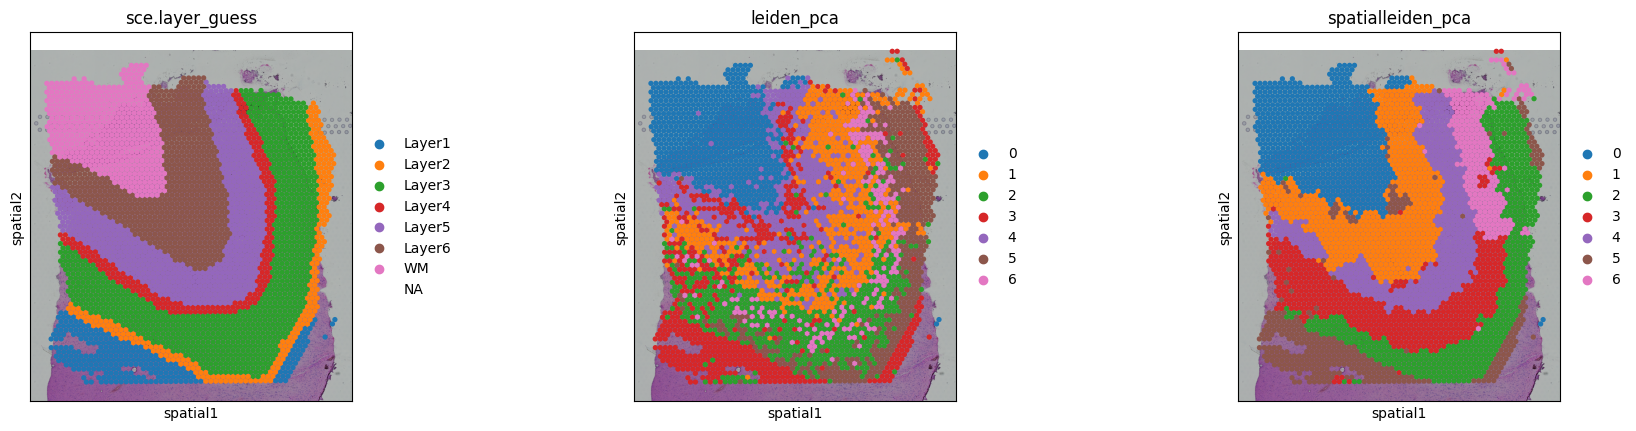

In [71]:
sc.pl.spatial(adata, color=['sce.layer_guess', 'leiden_pca', 'spatialleiden_pca'], size = 1.5)

C:\Users\marya\AppData\Local\Temp\ipykernel_20892\3663996954.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


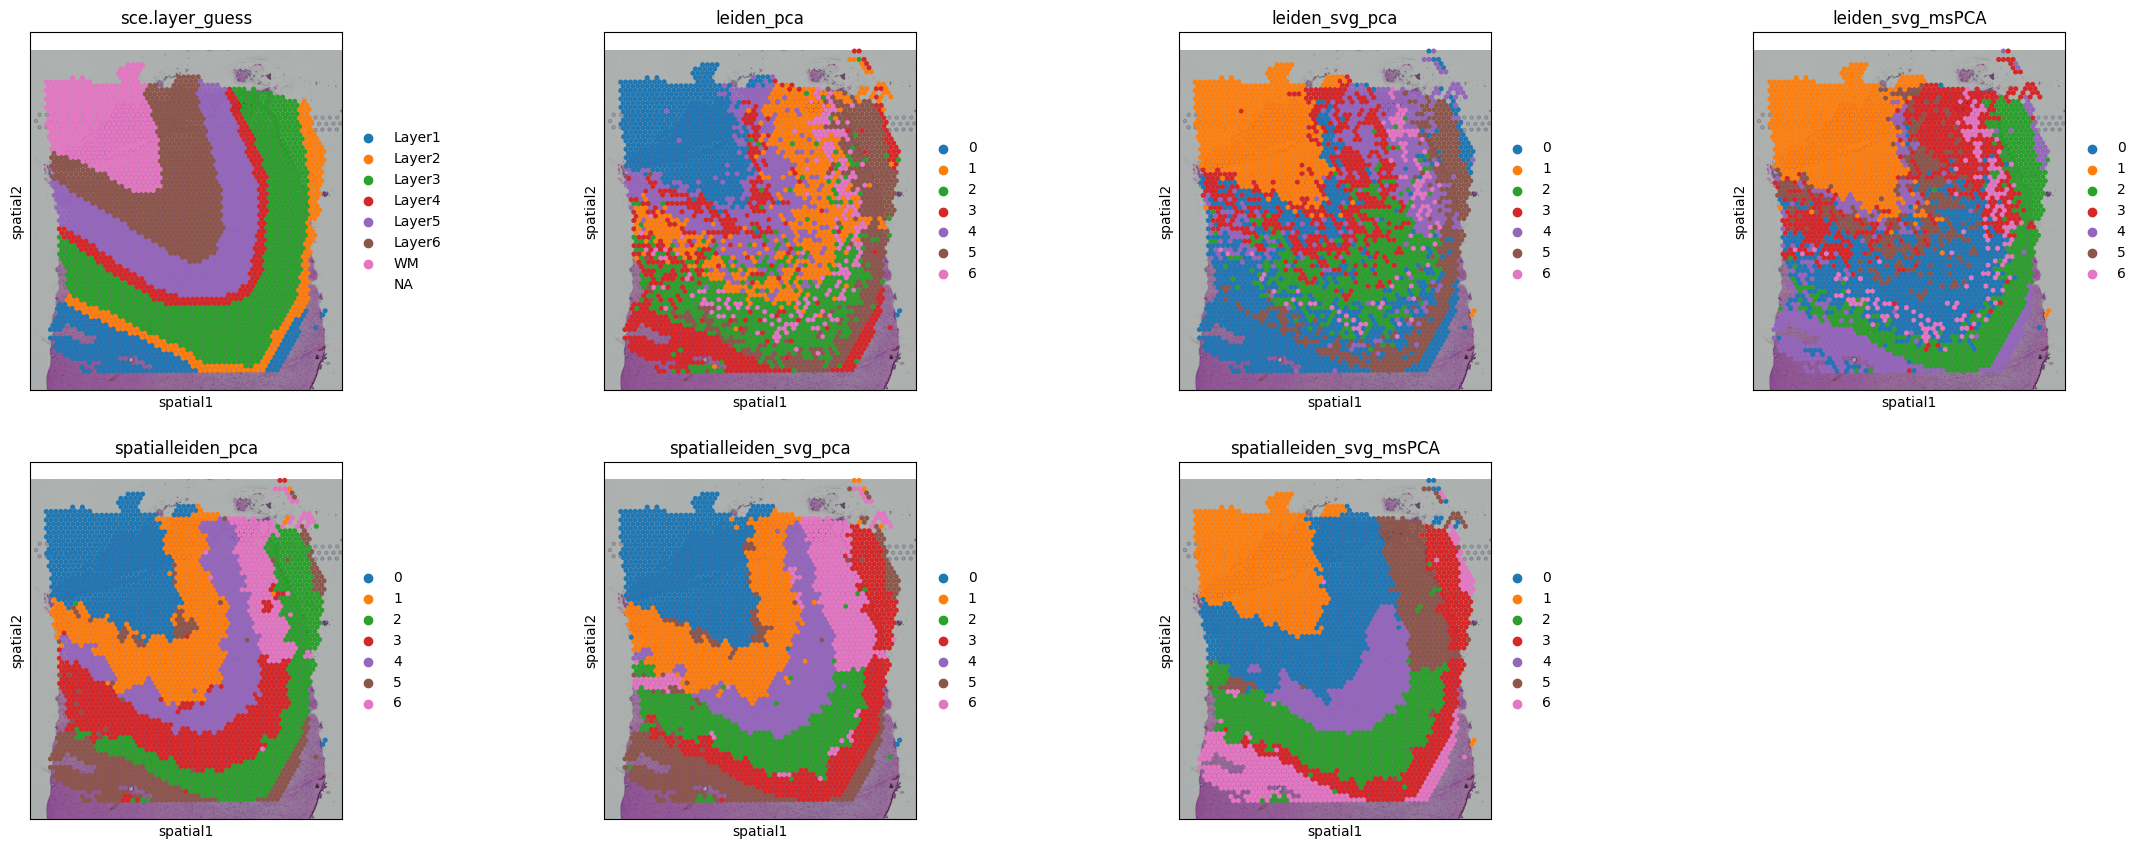

In [72]:
sc.pl.spatial(
    adata,
    color=['sce.layer_guess',
        'leiden_pca',
        'leiden_svg_pca',
        'leiden_svg_msPCA',
        'spatialleiden_pca',
        'spatialleiden_svg_pca',
        'spatialleiden_svg_msPCA'
        ],
    ncols=4,  # or 3, depending on your layout
    wspace=0.1,
    hspace=0.2,
    size=1.5,
)

C:\Users\marya\AppData\Local\Temp\ipykernel_20892\3804279304.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


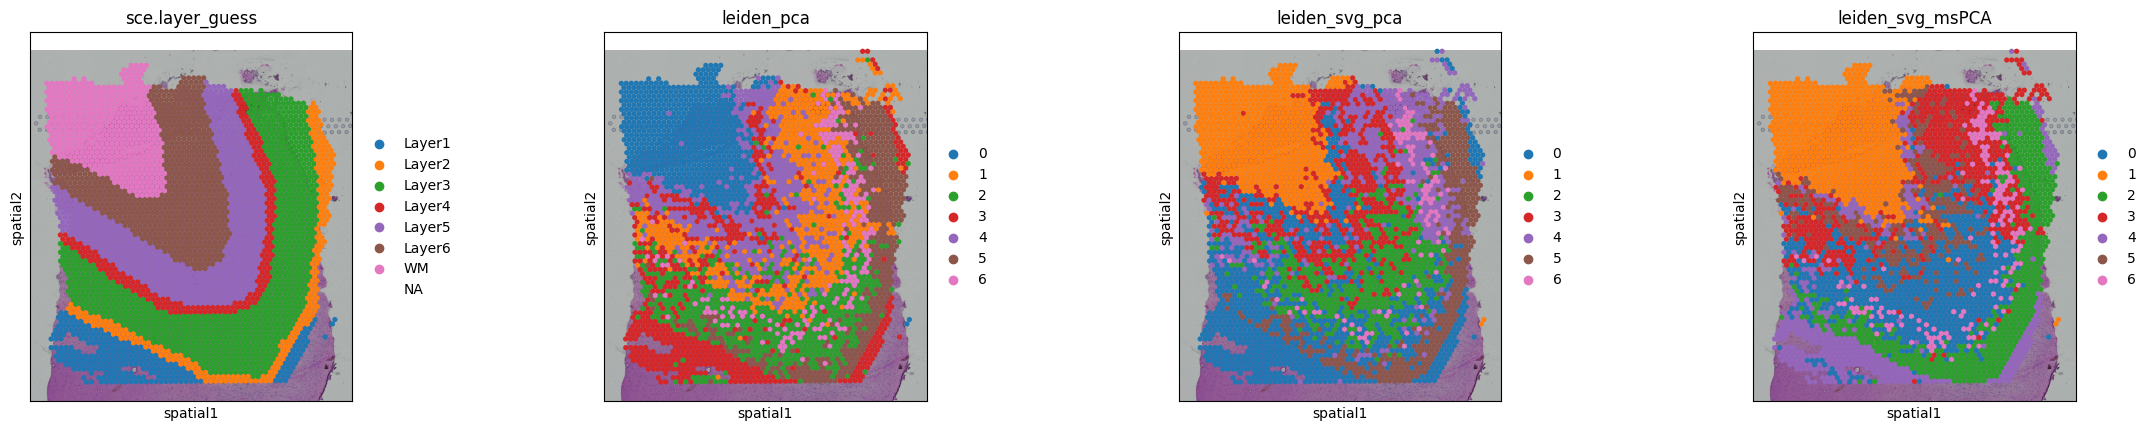

In [73]:
sc.pl.spatial(
    adata,
    color=['sce.layer_guess',
        'leiden_pca',
        'leiden_svg_pca',
        'leiden_svg_msPCA',
        ],
    ncols=4,  # or 3, depending on your layout
    wspace=0.1,
    hspace=0.2,
    size=1.5,
)

C:\Users\marya\AppData\Local\Temp\ipykernel_20892\1907262356.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


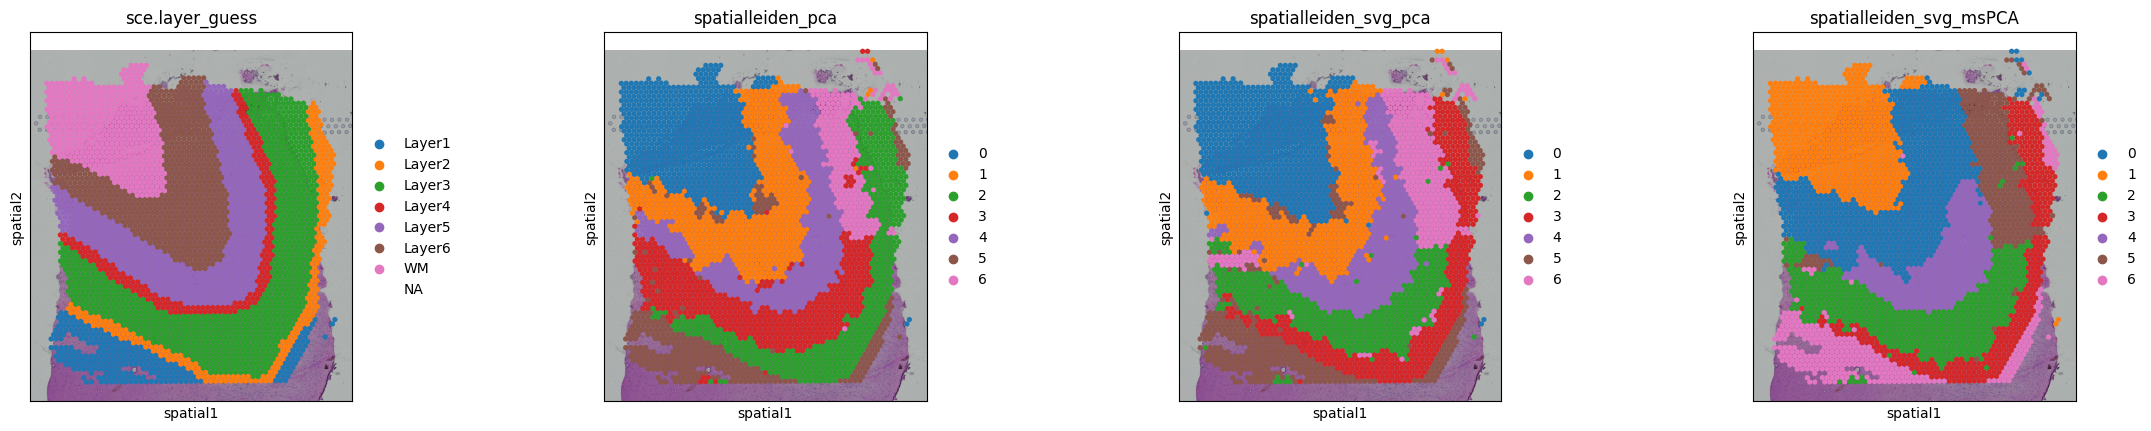

In [74]:
sc.pl.spatial(
    adata,
    color=['sce.layer_guess',
        'spatialleiden_pca',
        'spatialleiden_svg_pca',
        'spatialleiden_svg_msPCA',
        ],
    ncols=4,  # or 3, depending on your layout
    wspace=0.1,
    hspace=0.2,
    size=1.5,
)


Code adapted from github from orignal SpatialLeiden paper [1] and follows from the spatialleiden documentation

1. Müller-Bötticher, N., Sahay, S., Eils, R. et al. SpatialLeiden: spatially aware Leiden clustering. Genome Biol 26, 24 (2025). https://doi.org/10.1186/s13059-025-03489-7

In [ ]:
Code 